### OCR Demo

In [ ]:
import os
import cv2

from glob import glob
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

from BDRC.data import OpStatus
from BDRC.exporter import JsonExporter, PageXMLExporter, TextExporter
from BDRC.inference import OCRPipeline

from BDRC.utils import show_image, show_overlay, create_dir, get_filename, read_line_model_config, read_layout_model_config, read_ocr_model_config

d:\Github\BDRC\ocr-inference\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
data_path = "C:/Users/Eric/Downloads/W23228"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

xml_exporter = PageXMLExporter(output_dir)
json_exporter = JsonExporter(output_dir)
text_exporter = TextExporter(output_dir)

img_ext = "tif"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 296


(1216, 6752, 3)
C:/Users/Eric/Downloads/W23228\08660013.tif
08660013


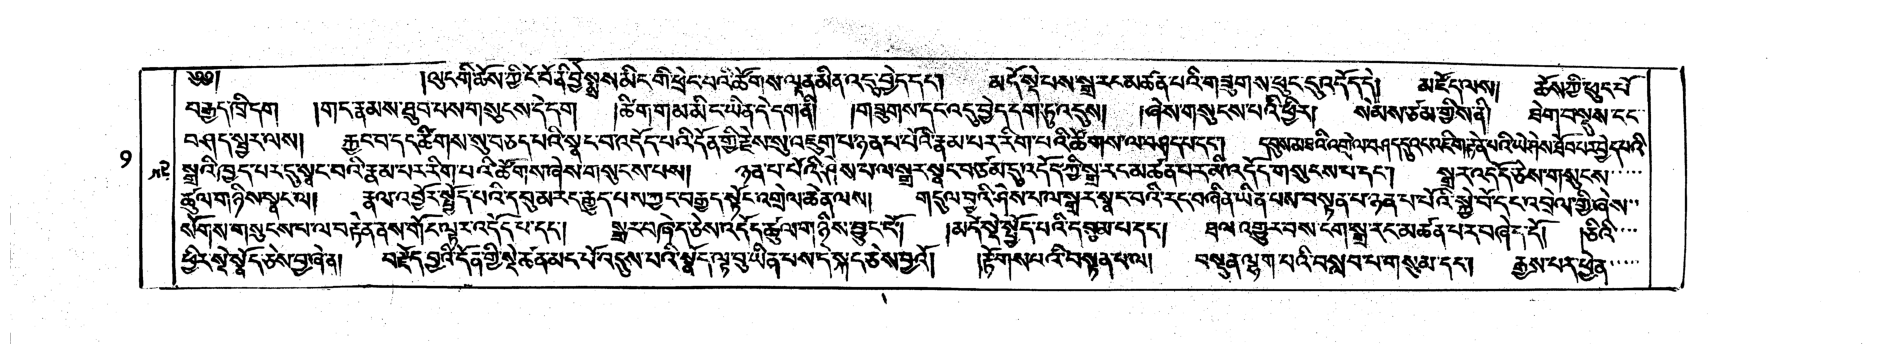

In [25]:
idx = 12
img = cv2.imread(image_paths[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
print(image_paths[idx])
image_name = get_filename(image_paths[idx])
print(image_name)
show_image(img)

#### OCR via Pipelines using a line or layout model

In [26]:
# run download_al_models.py to download models and configs from HuggingFace

line_model_config_file = "Models/BDRC/PhotiLines/config.json"
layout_model_config_file = "Models/BDRC/Photi-v2/config.json"

line_model_config = read_line_model_config(line_model_config_file)
layout_model_config = read_layout_model_config(layout_model_config_file)
#modern_layout_model_config = read_layout_model_config(modern_layout_config_file)

In [ ]:
# OCR pipeline with woodblock mdoel and layout model
#ocr_model_config_file = "Models/BDRC/Woodblock/model_config.json"
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)
ocr_pipeline = OCRPipeline(ocr_model_config, layout_model_config, False)

In [28]:
status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

if status == OpStatus.SUCCESS:
    for ocr_line in ocr_result[2]:
        print(ocr_line.text)

།༄་༎ལུང་གི་ཆོས་ཀྱི་ངོ་བོ་ནི་བྱེ་སྨྲས་མིང་གི་ཕྲེང་བའི་ཚོགས་ལྡན་མིན་འདུ་བྱེད་དང་།མདོ་སྡེ་པས་སྒྲ་རང་མཚན་པའི་གཟུགས་ཕུང་དུ་འདོད་དེ།མཛོད་ལས།ཆོས་ཀྱི་ཕུན་པ་།
།བརྒྱད་ཁྲི་དག།གད་རྣམས་ཐུབ་པས་གསུངས་དེ་དག།ཚིག་གམ་མིང་ཡིན་དེ་དག་ནི༎གཟུགས་དང་འདུ་བྱེད་དག་ཏུ་འདུས༎ཞེས་གསུངས་པའི་ཕྱིར།སེམས་ཙམ་གྱིས་ནི།ཐེག་བསྡུས་ངང་།
།བཤད་སྦྱར་ལས།རྐྱང་བ་དང་ཚིགས་སུ་བཅད་པའི་སྣང་བ་འདོད་པའི་དོན་གྱི་རྗེས་སུ་འཇུག་པ་ཉན་པ་པོའི་རྣམ་པར་རིག་པའི་ཚོགས་ལ་བཤད་པ་དང་།དབུས་མཐའི་འགྲེལ་བཤད་དུའང་འཇིག་རྟེན་པའི་ཡེ་ཤེས་ཐོབ་པར་བྱེད་པའི་།
།སྒྲའི་ཁྱད་པར་དུ་སྣང་བའི་རྣམ་པར་རིག་པའི་ཚོགས་ཞེས་གསུངས་པས།ཉན་པ་པོའི་ཤེས་པ་ལ་སྒྱུར་སྣང་བཙམ་དུ་འདོད་ཀྱི་སྒྲུ་རང་མཚན་པར་མི་འདོད་གསུངས་པ་དང་།སྒྱུར་འདོད་ཅེས་གསུངས་།
།ཚུལ་གཉིས་སྣང་ལ།རྣལ་འབྱོར་སྤྱོད་པའི་དབུ་མ་རང་རྒྱུད་པས་ཀྱང་བརྒྱད་སྟོང་འགྲེལ་ཆེན་ལས།གདུལ་བྱའི་ཤེས་པ་ལ་སྒུར་སྣང་བའི་རང་བཞིན་ཡིན་པས་བསྟན་པ་ཉན་པ་པོའི་སྐྱེ་བོ་དང་འབྲེལ་གྱི་ཞེས་།
།སོགས་གསུངས་པ་ལ་བརྟེན་ནས་གོང་ལྟར་འདོད་པ་དང་།སླར་བཞེད་ཅེས་འདོད་ཚུལ་གཉིས་བྱུང་ངོ་༎མདོ་སྡེ་སྤྱོད་པའི་དབུམ་པ་དང་།ཐལ་འགྱུར་བབས་ངག་སྒྲ་རང་མཚན་པར་བཞེད་དོ༎ཅིའི་།
།ཕྱིར་སྡེ་སྣོད་ཅེས་བྱ་ཞེ་ན།བརྗོད་བྱའི

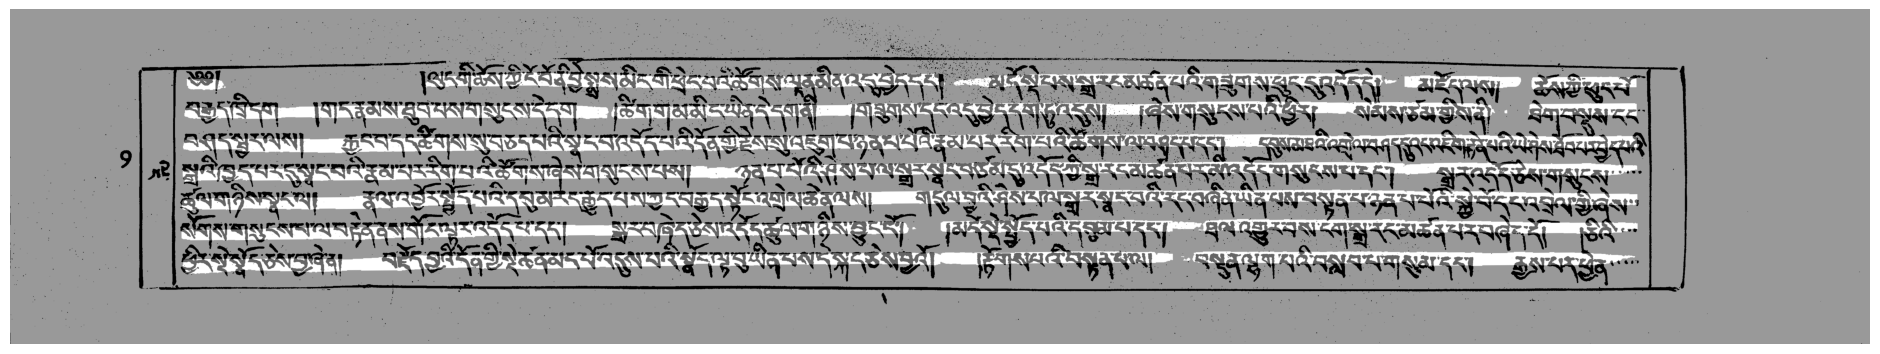

In [8]:
rot_mask, lines, ocr_lines, angle = ocr_result

show_overlay(img, rot_mask)

#### Single Volume

In [ ]:
# single volume
data_path = "C:/Users/Eric/Downloads/W23228"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

text_exporter = TextExporter(output_dir)
xml_exporter = PageXMLExporter(output_dir)

img_ext = "tif"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

if len(image_paths) > 0:
    for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image_name = get_filename(image_path)

        page_name = os.path.basename(image_path)
        base = os.path.splitext(page_name)[0]
        img = cv2.imread(image_path)
        status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

        if status == OpStatus.SUCCESS:
            _, lines, ocr_lines, angle = ocr_result
            if len(ocr_result[2]) > 0:
                xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                text_exporter.export_lines(img, base, lines, ocr_lines)

#### Run Multiple Volumes

In [ ]:
# run on all data
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)

work_id = "W22081_all"
root_dir = "C:/Users/Eric/Downloads/W22081_all"

output_dir = os.path.join(root_dir, "Output")
create_dir(output_dir)

ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

for sub_dir in Path(root_dir).iterdir():
    if sub_dir.name == "Output":
        continue
    
    if f"{work_id}" in str(sub_dir) and os.path.isdir(sub_dir):

        volume_out = os.path.join(output_dir, str(sub_dir.name))

        if os.path.exists(volume_out):
            continue

        create_dir(volume_out)
        print(volume_out)
        text_exporter = TextExporter(volume_out)
        xml_exporter = PageXMLExporter(volume_out)

        img_ext = "tif"
        image_paths = natsorted(glob(f"{sub_dir}/*.{img_ext}"))
        print(f"{sub_dir.name} => Images: {len(image_paths)}")

        if len(image_paths) > 0:
            for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
                page_name = os.path.basename(image_path)
                base = os.path.splitext(page_name)[0]
                img = cv2.imread(image_path)
                status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

                if status == OpStatus.SUCCESS:
                    _, lines, ocr_lines, angle = ocr_result
                    if len(ocr_result[2]) > 0:
                        xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                        text_exporter.export_lines(img, base, lines, ocr_lines)